In [772]:
import math
import numpy as np
import scipy as sci
import sympy as sym
from numpy.linalg import eig
from scipy.linalg import null_space
from sage.geometry.polyhedron.ppl_lattice_polytope import LatticePolytope_PPL

In [1003]:
#Functions 

#Assigning variables to divisors
def divgen(n,toruscoords):
    var = [0] * n
    letvar = [0] * toruscoords
    lettersf=['X', 'Y', 'Z', 'L', 'M', 'N','P', 'Q']
    for i in range(toruscoords):
        var[i]=sym.symbols(lettersf[i])
        letvar[i]=lettersf[i]
    for i in range(toruscoords,n):
        var[i]=sym.expand(sym.symbols('a_' +str(i)))
    return letvar,var

#Hypersurface coefficients
def coeffgen(n):
    var = [0] * n
    for i in range(n):
        var[i]=sym.expand(sym.symbols('c_' +str(i)))
    return var

#Batryev construction (vertices to Calabi-Yau hypersurface)
def batryev(polyp,dualp,arrcoeff,arrcoords):
    hyp=0
    for i in range(len(dualp)):
        t=1
        coeff=arrcoeff[i]
        for j in range(len(polyp)):
            t1=arrcoords[j]**(np.dot(polyp[j],dualp[i])+1)
            t=t*t1
        hyp=hyp+coeff*t
    return hyp

#Blown-down hypersurface
def singmodel(model,coords,divs,nbdowndivs):
    tempbk=list()
    for i in range(len(nbdowndivs)):
        tempbk.append(nbdowndivs[i][0])
    for j in range(len(divs)):
        if divs[j] not in tempbk:
            model=model.subs({coords[j]:1})
    return model

#Identify flavor symmetry
def nfflavs(letvar,divs,divsbase,baseindex1,baseindex2):
    kaps=len(letvar)
    flavs=list()
    for i in range(len(divs)):
        if (divsbase[i][baseindex1]!=0 and divsbase[i][baseindex2]==0) or divsbase[i][baseindex2]<0:
            flavs.append(divs[i])
    return flavs

#Identifying non-flat fibers
def idnf(letvar,divs,divsbase,coords,targetdivs,baseindex1,baseindex2):
    kaps=len(letvar)
    nbdowns=list()
    nbcoords=list()
    for i in range(len(divs)):
        if divs[i] in targetdivs:
            nbdowns.append([divs[i],divsbase[i]])
            nbcoords.append(coords[i])
        elif i in range(kaps):
            nbdowns.append([divs[i],divsbase[i]])
            nbcoords.append(coords[i])            
    return nbdowns, nbcoords

#Removing non-flat fibers
def remnf(letvar,model,nbcoords,nbdowns,divs,divsbase,coords):
    nfindex=list()
    temp=divs.copy()
    tempb=divsbase.copy()
    tempc=coords.copy()
    for i in range(len(nbcoords)):
        if len(sym.Add.make_args(model.subs({nbcoords[i]:0})))==1:
            print(sym.Add.make_args(model.subs({nbcoords[i]:0})))
            inds=tempc.index(sym.symbols(str(nbcoords[i])))
            print(temp[inds])
            temp.remove(temp[inds])
            tempb.remove(tempb[inds])
            if str(tempc[inds]) in letvar:
                letvar.remove(str(tempc[inds]))
            tempc.remove(tempc[inds])
            nfindex.append(i)
            print(len(nfindex))
    return letvar,model,temp,tempb, tempc,nfindex,nbcoords,nbdowns

#Getting base divisors
def getbasedivs(divs,baseindex1,baseindex2):
    basedivs=list()
    for j in range(len(divs)):
        if (divs[j][baseindex1]!=0 or divs[j][baseindex2]!=0):
            basedivs.append(([int(divs[j][baseindex1]/(math.gcd(divs[j][baseindex1],divs[j][baseindex2]))),int(divs[j][baseindex2]/(math.gcd(divs[j][baseindex1],divs[j][baseindex2])))]))
    return basedivs

#Unique base divisors
def undivs(divs):
    undivs=list()
    for i in range(len(divs)):
        if divs[i] not in undivs:
            undivs.append(divs[i])
    return undivs

#Slopes of compact base divisors
def slcomp(divs):
    slopes=list()
    compactdivs=list()
    
    for i in range(len(divs)):
        if divs[i][1]>0:
            if divs[i][0]>0:
                slopes.append(math.degrees(math.atan(divs[i][1]/divs[i][0])))
            if divs[i][0]<0:
                slopes.append(math.degrees(math.atan(divs[i][1]/divs[i][0]))+180)
            if divs[i][0]==0:
                slopes.append(90)
    
    #Arranging
    slopes.sort()
    for i in range(len(slopes)):
        for j in range(len(divs)):
            if divs[j][1]>0:
                if divs[j][1]>0 and divs[j][0]>0 and slopes[i]==math.degrees(math.atan(divs[j][1]/divs[j][0])):
                    compactdivs.append(divs[j]) 
                if divs[j][1]>0 and divs[j][0]<0 and slopes[i]==math.degrees(math.atan(divs[j][1]/divs[j][0]))+180:
                    compactdivs.append(divs[j])
                if divs[j][0]==0 and slopes[i]==90:
                    compactdivs.append(divs[j])
    return compactdivs,slopes

#Computing base intersections
def selfints(divs):
    nums=list()
    nums.append('flavor curve')
    for i in range(len(divs)):
        if len(divs)==1:
            nums.append(0)
        elif i>0 and i<len(divs)-1:
            templ1=np.dot([0,1],divs[i+1])
            templ2=np.dot([0,1],divs[i-1])
            nums.append((templ1+templ2)/(-np.dot([0,1],divs[i])))
        elif i==0:
            templ1=np.dot([0,1],divs[i+1])
            nums.append((templ1)/(-np.dot([0,1],divs[i])))
        elif i==len(divs)-1:
            templ2=np.dot([0,1],divs[i-1])
            nums.append((templ2)/(-np.dot([0,1],divs[i])))
    nums.append('flavor curve')
    return nums

#Neighboring divisors
def neighdiv(basedivs,checkdiv):
    temp=slcomp(undivs(basedivs))[0]
    inds=temp.index(checkdiv)
    if inds==0:
        return temp[inds],temp[inds+1]
    elif inds==len(temp)-1:
        return temp[inds-1],temp[inds]
    else:
        return temp[inds-1],temp[inds],temp[inds+1]

    
#Get 4D vertices from base vertices
def get4Dvert(divs2D,divs4D,divsbase,baseindex1,baseindex2):
    temp=list()
    temp2=list()
    for i in range(len(divsbase)):
         temp.append([divsbase[i][baseindex1],divsbase[i][baseindex2]])
    for i in range(len(temp)):
        if temp[i][0]!=0 or temp[i][1]!=0:
            if [temp[i][0]/math.gcd(int(temp[i][0]),int(temp[i][1])),temp[i][1]/math.gcd(int(temp[i][0]),int(temp[i][1]))] in divs2D:
                temp2.append(divs4D[i])
    return temp2
        

#Final model (non-flat fibers removed)
def finalmodel(letvar,model,checkdiv,divs,divsbase,bdivs,coords,baseindex1,baseindex2):
    klo=neighdiv(bdivs,checkdiv)
    cap=get4Dvert(klo,divs,divsbase,baseindex1,baseindex2)
    #Add torus coordinates
    for i in range(len(letvar)):
        cap.append(divs[i])
    nbdowns,nbcoords=idnf(letvar,divs,divsbase,coords,cap,baseindex1,baseindex2)
    nf=singmodel(model,coords,divs,nbdowns)
    nf2=sym.collect(nf,sym.symbols(letvar))
    return remnf(letvar,nf2,nbcoords,nbdowns,divs,divsbase,coords)


#Final quiver data
def quiverdata(letvar,model,checkdivs,divs,divsbase,bdivs,coords,baseindex1,baseindex2):
    nfsdat=list()
    if len(checkdivs)!=0:
        for i in range(len(checkdivs)):
            letvar,modelf,kpf,divsbasef,kcoordsf,nfindexf,nbcoordsf,nbdownsf=finalmodel(letvar,model,checkdivs[i],divs,divsbase,bdivs,coords,baseindex1,baseindex2)
            nfsdat.append([modelf,kpf,divsbasef,kcoordsf,nfindexf,nbcoordsf,nbdownsf])
            if len(nfindexf)!=0:    
                for i in range(len(nfindexf)):
                    model=model.subs({nbcoordsf[nfindexf[i]]:1})
            divs=kpf
            divsbase=divsbasef
            bdivs=getbasedivs(divsbasef,baseindex1,baseindex2)
            coords=kcoordsf
    else:
        nfsdat.append([model,divs,divsbase,coords,[],[],[[],[]]])
    return nfsdat

#Check number of non-kahler intersections for the non-flat fibers
def numint(letvar,quivs,multipli,checkdivs,baseindex1,baseindex2):   
    if len(quivs[4])!=0:
        quivs[0]=sym.Add.make_args(quivs[0].subs({quivs[5][quivs[4][multipli]]:0}))[0]
        tempty=list()
        for i in range(len(quivs[-1])):
            tempty.append([quivs[-1][i][1][baseindex1],quivs[-1][i][1][baseindex2]])
        for i in range(len(quivs[5])):
            if i not in range(len(letvar)):
                if [tempty[i][0]/math.gcd(int(tempty[i][0]),int(tempty[i][1])),tempty[i][1]/math.gcd(int(tempty[i][0]),int(tempty[i][1]))]==checkdivs:
                    quivs[0]=sym.Add.make_args(quivs[0].subs({quivs[5][i]:1}))[0]
        kaps=quivs[0].args[1]
        kaps2=sym.collect(kaps,sym.symbols(letvar))
        degree=int(sym.degree(kaps2.args[1].as_poly()))
        return degree,'flat fiber with ' +str(degree)+' solutions'
    else:
        return 'No flat fiber on this divisor'




#Quiver
def basedata(divs,divsbase,nonflatdat,baseindex1,baseindex2):
    l1=baseindex1
    l2=baseindex2
    gaugevert=list()
    tempgdivs=list()
    for i in range(len(divs)):
        gaugevert.append([])
        if (divsbase[i][l1]!=0 or divsbase[i][l2]!=0):
            compt=([divsbase[i][l1]/(math.gcd(divsbase[i][l1],divsbase[i][l2])),divsbase[i][l2]/(math.gcd(divsbase[i][l1],divsbase[i][l2]))]) 
            if compt not in tempgdivs:
                tempgdivs.append(compt)
                gaugevert[i].append([divs[i],divsbase[i]])
                for j in range(len(divs)):
                    if (divsbase[j][l1]!=0 or divsbase[j][l2]!=0):
                        compt2=([divsbase[j][l1]/(math.gcd(divsbase[j][l1],divsbase[j][l2])),divsbase[j][l2]/(math.gcd(divsbase[j][l1],divsbase[j][l2]))])
                        if compt2==compt and i!=j:  
                            gaugevert[i].append([divs[j],divsbase[j]])
    fgaugevert=list()
    for i in range(len(gaugevert)):
        if len(gaugevert[i])>0 and gaugevert[i][0][1][l2]>=0:
            fgaugevert.append(gaugevert[i])
    arrtempg=list()
    arrtempg.append(0)
    
    basedivstemp=list()
    for j in range(len(divs)):
        if (divsbase[j][l1]!=0 or divsbase[j][l2]!=0):
            basedivstemp.append(([divsbase[j][l1]/(math.gcd(divsbase[j][l1],divsbase[j][l2])),divsbase[j][l2]/(math.gcd(divsbase[j][l1],divsbase[j][l2]))]))

    for i in range(len(slcomp(undivs(basedivstemp))[1])):
        arrtempg.append(slcomp(undivs(basedivstemp))[1][i])
    intersecs=selfints(slcomp(undivs(basedivstemp))[0])    
    arrtempg.append(180)
    arrvert=list()
    for j in range(len(arrtempg)):
        for i in range(len(fgaugevert)):
            if fgaugevert[i][0][1][l1]<0:
                sema=math.degrees(math.atan(fgaugevert[i][0][1][l2]/fgaugevert[i][0][1][l1]))+180
            if fgaugevert[i][0][1][l1]>0:
                sema=math.degrees(math.atan(fgaugevert[i][0][1][l2]/fgaugevert[i][0][1][l1]))
            if fgaugevert[i][0][1][l1]==0:
                sema=90
            if sema==arrtempg[j]:
                arrvert.append(fgaugevert[i])
    kaclabels=list()
    for i in range(len(arrvert)):
        kaclabels.append([])
        for j in range(len(arrvert[i])):
            kaclabels[i].append(math.gcd(arrvert[i][j][1][l1::l2-l1][0],arrvert[i][j][1][l1::l2-l1][1]))
        for k in range(len(nonflatdat)):
            if len(nonflatdat[k])!=0:
                if nonflatdat[k][0] in arrvert[i]:
                    for m in range(nonflatdat[k][1]-1):
                        kaclabels[i].append(1)
                
    CBdim=len(intersecs)-2
    for i in range(len(kaclabels)):
        if i==0 or i==len(kaclabels)-1:
            kaclabels[i].append(['rank ' +str(len(kaclabels[i])-1)+ ' flavor group'])
        else:
            kaclabels[i].append(['rank ' +str(len(kaclabels[i])-1)+ ' gauge group on '+ str(int(abs(intersecs[i])))+' curve'])
            if len(kaclabels[i])>2:
                CBdim=CBdim+len(kaclabels[i])-2
    return kaclabels,CBdim-1

#Little string charges
def lscharge(divs):    
    selfs=selfints(slcomp(undivs(divs))[0])
    selfs.pop(0)
    selfs.pop(-1)
    intmat= np.zeros((len(selfs),len(selfs)))
    for i in range(len(selfs)):
        for j in range(len(selfs)):
            if j==i+1 or j==i-1:
                intmat[i,j]=1
            elif i==j:
                intmat[j,j]=selfs[i]
            else:    
                intmat[i,j]=0
    ns = null_space(intmat)
    LScharges=abs(ns/-min(abs(ns)))
    return intmat,LScharges

In [1004]:
#Get 4D reflexive polytope (Pick vertices)
vertices=[[-1, -2, 0, 0],   [-1, 2, 0, 0], [1,0,0,0]  , [-1, -2, 2, 0],
          [-1, -1, 2, 0],[-1, 0, 2, 0] ,[-1, 1, 2, 0] ,[-1, 2, 2, 0],
           [-1, -2, -2, 0],
          [-1, -1, -2, 0],[-1, 0, -2, 0] ,[-1, 1, -2, 0] ,[-1, 2, -2, 0],
           [-1, -2,  0, -1],  [-1,-2,0,4],[-1,-2,4,4]
          ];
P0 = Polyhedron(vertices)
if P0.is_reflexive():
    print('All Good');
    Ptest = LatticePolytope(vertices);
    print(Ptest.poly_x("g"));
else:
    PN = Polyhedron(vertices=P0.polar().integral_points())
    PM = PN.polar()
    print(PM.is_reflexive())
    Ptest=LatticePolytope(P0.polar().integral_points())
    print(Ptest.polar().poly_x("g"))
p=Ptest.polar()

True
M:119 8 N:18 8 H:10,92 [-164]



In [1005]:
#Get number of 2D reflexive subpolytopes/genus-one fibrations
K3=list()
lemp=p.points()
for i in range(len(lemp)):
    if lemp[i][3]==0:
        K3.append(lemp[i])
templo=list()
for i in range(len(K3)):
    templo.append([K3[i][0],K3[i][1],K3[i][2]])
shaba=LatticePolytope(templo)
shaba.points()
twodsub=list()
blks=shaba.vertices()
nk3=np.array(blks).tolist()
pq = LatticePolytope_PPL(nk3)
len(list(pq.fibration_generator(2)))

9

In [1006]:
#Pick a fibration
fibind=0
#Get polytope data
ct1=LatticePolytope(list(pq.fibration_generator(2))[fibind].integral_points()).plot3d(facet_color='red')
nm1=LatticePolytope(shaba.points()).plot3d(facet_color='white')
kaplz=LatticePolytope(list(pq.fibration_generator(2))[fibind].integral_points()).vertices()
kmn=np.array(kaplz).tolist()
oldnorm=np.cross(kmn[0], kmn[2])/(math.gcd(np.cross(kmn[0], kmn[2])[0],np.cross(kmn[0], kmn[2])[1],np.cross(kmn[0], kmn[2])[2]))
newnorm1=[0,0,1]
costheta = np.dot(oldnorm,newnorm1)/(np.linalg.norm(oldnorm)*np.linalg.norm(newnorm1))
ang=math.acos(costheta)
newnorm = np.cross(oldnorm, newnorm1) / np.linalg.norm(np.cross(oldnorm, newnorm1))
comp1=oldnorm.tolist()
comp1.append(1)
comp2=[0,0,0,1]
torusn=LatticePolytope(list(pq.fibration_generator(2))[fibind].integral_points()).vertices()
torus=np.array(torusn).tolist()
for i in range (len(torus)):
    torus[i].append(0)
torus.append([0,0,0,0])

In [1007]:
#2D reflexive subpolytope inside the 3D one
ct1+nm1

Graphics3d Object

In [1008]:
#Identify fiber coordinates
verts=p
poly_verts = LatticePolytope(verts)
temp=poly_verts.points()
polyp=np.array(temp)
#Rearranging
countemp=0
for j in range(len(polyp)):
    temp1=polyp.tolist()
    if temp1[j] in torus and temp1[j]!=[0,0,0,0]:
        polyp[countemp]=temp1[j]
        polyp[j]=temp1[countemp]
        countemp=countemp+1

In [1009]:
#Dual Polytope
dualpoly=poly_verts.polar()
dualpoly.is_reflexive()
tempp=dualpoly.points()
dualp=np.array(tempp)

In [1010]:
#Label divisors
letvar,arrcoords=divgen(len(polyp),len(torus)-1)
#coefficients
arrcoeff=coeffgen(len(dualp))

In [1011]:
#Hypersurface from Batryev
q=sym.expand(batryev(polyp,dualp,arrcoeff,arrcoords))

In [1012]:
#Remove divisors that don't intersect the CY (Ineffective)
ineff=list()
ineffin=list()
for j in range(len(polyp)):
    temp5=q.subs({arrcoords[j]:0})
    if len(sym.Add.make_args(temp5))==1:
        ineff.append(arrcoords[j])
        if str(arrcoords[j]) in letvar:
            letvar.remove(str(arrcoords[j]))
        ineffin.append(j)    

In [1013]:
#New list of divisors and labels
kp=polyp.tolist()  
kcoords=arrcoords.copy()
temp6=polyp.tolist()
for j in range(len(ineffin)):
    kp.remove(temp6[ineffin[j]])
    kcoords.remove(arrcoords[ineffin[j]])

In [1014]:
#CY hypersurface with ineffective divisors removed
weirs=sym.expand(batryev(kp,dualp,arrcoeff,kcoords))

In [1015]:
#Get 2D base of the fibration
baseindex1=0
baseindex2=1
newbase1=list()
for i in range(len(kp)):
    newbase1.append([int(np.dot(kp[i],comp1)),int(np.dot(kp[i],comp2))])

In [1016]:
#Get non-flat flavor divisors 
flavs=nfflavs(letvar,kp,newbase1,baseindex1,baseindex2)
nbdowns,nbcoords=idnf(letvar,kp,newbase1,kcoords,flavs,baseindex1,baseindex2)
nf=singmodel(weirs,kcoords,kp,nbdowns)
nf2=sym.collect(nf,sym.symbols(letvar))

In [1017]:
#Removing non-flat flavor divisors 
letvar,model,kp,newbase1,kcoords,nfindex,nbcoords,nbdowns=remnf(letvar,nf2,nbcoords,nbdowns,kp,newbase1,kcoords)

(Y**3*(Z*a_108**2*a_115**2*a_117*a_118**2*a_36*a_37**2*a_38*a_64**4*a_7**4*a_82**4*a_93**4*a_94**4*a_95**2*a_96**3*c_6 + Z*a_108**2*a_115**2*a_117*a_118**2*a_36*a_37**2*a_64**4*a_7**4*a_82**4*a_93**4*a_94**4*a_95**2*a_96**3*c_5),)
[0, 0, 1, 0]
1
(Y*(Z**3*a_106**2*a_113**2*a_116**2*a_117*a_3**4*a_36**3*a_37**2*a_38**2*a_6**4*a_60**4*a_78**4*a_89**4*a_95**2*a_96*c_2 + Z**3*a_106**2*a_113**2*a_116**2*a_117*a_3**4*a_36**3*a_37**2*a_38*a_6**4*a_60**4*a_78**4*a_89**4*a_95**2*a_96*c_12 + Z**3*a_106**2*a_113**2*a_116**2*a_117*a_3**4*a_36**3*a_37**2*a_6**4*a_60**4*a_78**4*a_89**4*a_95**2*a_96*c_3),)
[0, 0, -1, 0]
2
(Y**4*(a_106**2*a_108**2*a_113*a_115*a_36**4*a_37**4*a_38**5*a_6**4*a_60**3*a_64**3*a_7**4*a_78**2*a_82**2*a_89*a_93*c_1 + a_106**2*a_108**2*a_113*a_115*a_36**4*a_37**4*a_38**4*a_6**4*a_60**3*a_64**3*a_7**4*a_78**2*a_82**2*a_89*a_93*c_11 + a_106**2*a_108**2*a_113*a_115*a_36**4*a_37**4*a_38**3*a_6**4*a_60**3*a_64**3*a_7**4*a_78**2*a_82**2*a_89*a_93*c_10 + a_106**2*a_108**2*a_113*a_115

In [1018]:
#New hypersurface
weirs=sym.expand(batryev(kp,dualp,arrcoeff,kcoords))

In [1019]:
#New base
newbase=list()
for i in range(len(kp)):
    newbase.append([int(np.dot(kp[i],comp1)),int(np.dot(kp[i],comp2))])

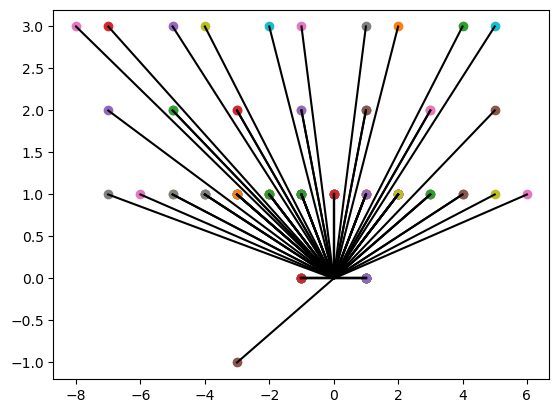

In [1020]:
#Plot 2D base with gauge/flavor divisors
from matplotlib import pyplot as plt
basedivs=getbasedivs(newbase,baseindex1,baseindex2)
xc=list()
yc=list()
for j in range(len(basedivs)):
    xc.append(basedivs[j][0])
    yc.append(basedivs[j][1])
for i in range(len(basedivs)):
    x = xc[i]
    y = yc[i]
    plt.scatter(x, y, marker = 'o')

    # V this adds the lines V
    plt.plot([0,xc[i]], [0, yc[i]], color="black")
    # ^ this adds the lines ^

    plt.plot(x,y,0,0, linestyle = '--' )

In [1021]:
#Ranks of gauge algebras On base divisors
#rank=1 indicates no gauge group (empty tensor)
ranks=list()
temp=basedivs.copy()
divsk=slcomp(undivs(temp))[0]
for i in range(len(divsk)):
    ranks.append(0)
    for j in range(len(temp)):
        if temp[j]==divsk[i]:
            ranks[i]=ranks[i]+1

In [1022]:
#Get naive quiver with Coulomb branch dimension (non-flat divisors not removed)
basedata(kp,newbase,[],baseindex1,baseindex2)

([[2, 3, 4, 5, 6, 2, 4, 1, 3, ['rank 8 flavor group']],
  [1, ['rank 0 gauge group on 1 curve']],
  [1, ['rank 0 gauge group on 2 curve']],
  [1, 1, ['rank 1 gauge group on 2 curve']],
  [1, 2, 1, ['rank 2 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 3, 2, 1, 1, ['rank 4 gauge group on 5 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 1, ['rank 1 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [4, 3, 2, 1, 2, ['rank 4 gauge group on 6 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 1, ['rank 1 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [4, 2, 3, 2, 1, ['rank 4 gauge group on 6 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 1, ['rank 1 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [4, 3, 2, 1, 2, ['rank 4 gauge group on 6 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 1, ['rank 1 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 cur

In [1023]:
#Base coordinates
slcomp(undivs(basedivs))

([[6, 1],
  [5, 1],
  [4, 1],
  [3, 1],
  [5, 2],
  [2, 1],
  [5, 3],
  [3, 2],
  [4, 3],
  [1, 1],
  [2, 3],
  [1, 2],
  [1, 3],
  [0, 1],
  [-1, 3],
  [-1, 2],
  [-2, 3],
  [-1, 1],
  [-4, 3],
  [-3, 2],
  [-5, 3],
  [-2, 1],
  [-7, 3],
  [-5, 2],
  [-8, 3],
  [-3, 1],
  [-7, 2],
  [-4, 1],
  [-5, 1],
  [-6, 1],
  [-7, 1]],
 [9.462322208025617,
  11.309932474020215,
  14.036243467926479,
  18.43494882292201,
  21.80140948635181,
  26.565051177077994,
  30.96375653207352,
  33.690067525979785,
  36.86989764584402,
  45.0,
  56.309932474020215,
  63.43494882292202,
  71.56505117707799,
  90,
  108.43494882292201,
  116.56505117707798,
  123.69006752597979,
  135.0,
  143.13010235415598,
  146.30993247402023,
  149.03624346792648,
  153.434948822922,
  156.80140948635182,
  158.19859051364818,
  159.44395478041653,
  161.56505117707798,
  164.05460409907715,
  165.96375653207352,
  168.69006752597977,
  170.53767779197437,
  171.86989764584402])

In [1024]:
#From 6D chiral anomalies, one identifies the problematic divisors (if any)
checkdivs=[[2,1]]

In [1025]:
#Getting non-flat fiber vertices with their multiplicities
nonflatdat=list()
nonflatdatT=list()
jk=quiverdata(letvar,weirs,checkdivs,kp,newbase,basedivs,kcoords,baseindex1,baseindex2)
for i in range(len(checkdivs)):
    if len(jk[i][4])!=0:
        for j in range(len(jk[i][4])):
            nfvert=jk[i][6][jk[i][4][j]][0]
            basecoordj=jk[i][6][jk[i][4][j]][1]
            nfdegree=numint(letvar,jk[i],j,checkdivs[i],baseindex1,baseindex2)[0]
            nonflatdat.append([nfvert,basecoordj,nfdegree])
    else:
        nonflatdatT.append([])
nftotdats=nonflatdat
nftotdats

[]

In [1026]:
#Final quiver data
modelf,kpf,newbasef,kcoordsf,nfindexf,nbcoordsf,nbdownsf=quiverdata(letvar,weirs,checkdivs,kp,newbase,basedivs,kcoords,baseindex1,baseindex2)[-1]
basedivsf=getbasedivs(newbasef,baseindex1,baseindex2)

In [1027]:
#Final quiver (note: blow-ups to cure non-flatness can be inferred)
basedata(kpf,newbasef,nftotdats,baseindex1,baseindex2)

([[2, 3, 4, 5, 6, 2, 4, 1, 3, ['rank 8 flavor group']],
  [1, ['rank 0 gauge group on 1 curve']],
  [1, ['rank 0 gauge group on 2 curve']],
  [1, 1, ['rank 1 gauge group on 2 curve']],
  [1, 2, 1, ['rank 2 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 3, 2, 1, 1, ['rank 4 gauge group on 5 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 1, ['rank 1 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [4, 3, 2, 1, 2, ['rank 4 gauge group on 6 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 1, ['rank 1 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [4, 2, 3, 2, 1, ['rank 4 gauge group on 6 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 1, ['rank 1 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [4, 3, 2, 1, 2, ['rank 4 gauge group on 6 curve']],
  [1, ['rank 0 gauge group on 1 curve']],
  [2, 1, ['rank 1 gauge group on 3 curve']],
  [1, ['rank 0 gauge group on 1 cur

In [1028]:
#Compute Two-Group structure constants (first include the new intersection data of blow-ups)
intmat,LScharges=lscharge(basedivsf)
kpoincare=0
kR=0
selfs=selfints(slcomp(undivs(basedivsf))[0])
selfs.pop(0)
selfs.pop(-1)
cf=basedata(kpf,newbasef,nftotdats,baseindex1,baseindex2)[0]
cf.pop(0)
cf.pop(-1)
for i in range(len(LScharges)):
    kpoincare=kpoincare-(LScharges[i]*(-selfs[i]-2))
for i in range(len(LScharges)):
    tempk=cf[i]
    tempk.pop(-1)
    kR=kR+((np.sum(tempk))*LScharges[i])

In [1029]:
#Full Two-Group data (k_P, k_R)
[round(kpoincare[0]),round(kR[0])]

[2.0, 146.0]